<a href="https://colab.research.google.com/github/Prasadkurapati7/Data-Mining-/blob/main/Data_Mining_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
import warnings

from PIL import Image
from skimage.color import rgb2gray
import xml.etree.ElementTree as ET
from skimage import io, exposure, filters

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

import matplotlib.pyplot as plt

In [3]:
warnings.filterwarnings("ignore")

## 1

In [4]:
def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

In [5]:
new_dir = "/content/drive/MyDrive/DM1/processed"

In [6]:
class_paths = os.listdir(new_dir)

In [7]:
class_names = [i[10:] for i in class_paths]

In [8]:
class_paths

['n02093647-Bedlington_terrier',
 'n02091244-Ibizan_hound',
 'n02105505-komondor',
 'n02099267-flat-coated_retriever']

In [9]:
class_names

['Bedlington_terrier', 'Ibizan_hound', 'komondor', 'flat-coated_retriever']

## 2

In [10]:
df = pd.DataFrame(columns = list(range(0,36))+['class'])
for class_ in class_paths:
  class_path = os.path.join(new_dir,class_)
  for filename in os.listdir(class_path):
    img = io.imread(os.path.join(class_path,filename))
    gray_sacle = rgb2gray(img)
    angle_sobel = angle(filters.sobel_h(gray_sacle),
                    filters.sobel_v(gray_sacle))
    hist,bins = exposure.histogram(angle_sobel,nbins=36)

    # print("here")
    for i in class_names:
      if i.lower() in class_.lower():
        break
    df.loc[len(df)] = list(hist)+[class_names.index(i)]




In [11]:
df.to_csv("/content/drive/MyDrive/DM1/hist_datset.csv")

In [12]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,class
0,416,402,406,386,415,434,430,405,421,453,...,396,387,381,383,420,377,408,405,401,0
1,525,413,401,377,353,340,336,350,369,379,...,433,433,438,448,473,523,573,645,630,0
2,713,492,442,435,407,416,395,425,388,413,...,433,413,460,470,488,455,488,515,497,0
3,1951,320,380,399,305,335,369,296,445,404,...,425,309,334,388,332,410,383,387,384,0
4,342,337,344,374,370,401,442,420,456,509,...,403,352,356,326,322,347,318,321,347,0


## 3

In [13]:
X = np.array(df[df.columns[:-1]])
y = np.array(df['class'])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

## 4,5

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [16]:
scalled_x_train= scaler.transform(X_train)
scalled_x_test = scaler.transform(X_test)

## 6

In [17]:
from sklearn.metrics import accuracy_score

In [20]:
classifiers = [DecisionTreeClassifier(max_depth=10),MLPClassifier(hidden_layer_sizes = (10, 10, 10, )), AdaBoostClassifier()]
classifier_names = ['Decision Tree', 'Neural Network','Ada Boost']

In [21]:
val_accs = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for classifier in classifiers:
  temp = []
  for fold, (start_train_index, val_index) in enumerate(skf.split(scalled_x_train, y_train)):
    X_start_train, X_val = scalled_x_train[start_train_index], scalled_x_train[val_index]
    y_start_train, y_val = y_train[start_train_index], y_train[val_index]
    classifier.fit(X_start_train, y_start_train)
    y_pred = classifier.predict(X_val)
    temp.append(accuracy_score(y_val,y_pred))
  val_accs.append(np.mean(temp))


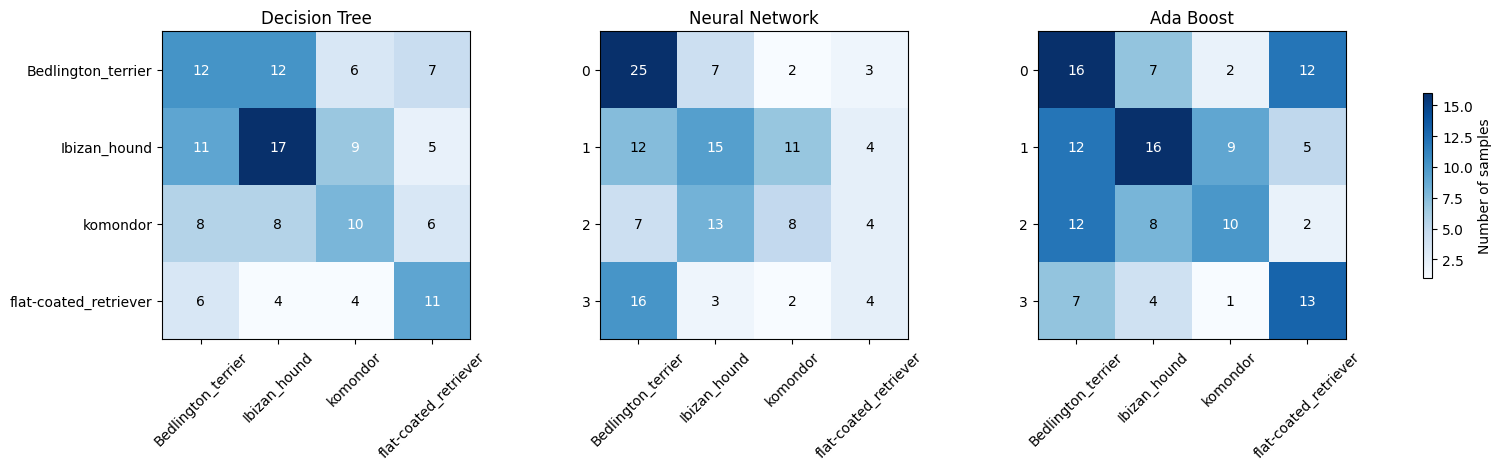

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))
ind = 0
for name, classifier in zip(classifier_names,classifiers):
  y_pred = classifier.predict(scalled_x_test)
  cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))

  im = axes[ind].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)


  axes[ind].set_xticks(np.arange(len(class_names)))
  axes[ind].set_yticks(np.arange(len(class_names)))
  axes[ind].set_xticklabels(class_names,rotation=45)
  if ind==0:
    axes[ind].set_yticklabels(class_names)
  axes[ind].set_title(name)

  for i in range(len(class_names)):
      for j in range(len(class_names)):
          axes[ind].text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
  ind+=1

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
cbar.ax.set_ylabel('Number of samples')



plt.show()


## 6 a

Ada boost is the the best bases on confusion matrix visualization as it has the best values diagnally

## 6 b

In [23]:
for clf_name, acc in zip(classifier_names,val_accs):
  print(f"{clf_name} Mean Val accuracy accross K folds {np.mean(acc)}")

Decision Tree Mean Val accuracy accross K folds 0.42037037037037034
Neural Network Mean Val accuracy accross K folds 0.4703703703703703
Ada Boost Mean Val accuracy accross K folds 0.40555555555555556


Neural Network is the best based on val accuracies

## 6 c,d

In [24]:
from sklearn.metrics import f1_score

In [25]:
test_acc = []
f_scores = []
for clf_name, clf in zip(classifier_names,classifiers):
  clf.fit(scalled_x_train,y_train)
  y_pred = clf.predict(scalled_x_test)
  test_acc.append(accuracy_score(y_test,y_pred))
  f_scores.append(f1_score(y_test, y_pred, average='micro'))


In [26]:
for clf_name, acc, f1 in zip(classifier_names,test_acc,f_scores):
  print(f"{clf_name} has Test accuracy  {acc} and F1 score {f1}")


Decision Tree has Test accuracy  0.3382352941176471 and F1 score 0.3382352941176471
Neural Network has Test accuracy  0.3897058823529412 and F1 score 0.3897058823529412
Ada Boost has Test accuracy  0.34558823529411764 and F1 score 0.34558823529411764


Neural Network is best in both Test accuracy and F1 score

## 7

In [36]:
new_df = df[df["class"].isin([2, 1])]

In [37]:
X = np.array(new_df[new_df.columns[:-1]])
y = np.array(new_df['class'])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [39]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [40]:
scalled_x_train= scaler.transform(X_train)
scalled_x_test = scaler.transform(X_test)

In [41]:
mean_val_errors_std = []
mean_val_errors_strat = []
mean_train_errors_std = []
mean_train_errors_strat = []
k_values = [0.1,1,10,100]
for k in k_values:
    # Standard 5-fold cross-validation
    kf = KFold(n_splits=5,shuffle=True)
    model1 = LinearSVC(C = k )
    train_scores_std = model1.fit(scalled_x_train, y_train).score(scalled_x_train, y_train)
    val_scores_std = cross_val_score(model1, scalled_x_train, y_train, cv=kf)
    mean_val_errors_std.append(np.mean(val_scores_std))
    mean_train_errors_std.append(train_scores_std)

    model2 = LinearSVC(C = k )
    skf = StratifiedKFold(n_splits=5,shuffle=True)
    train_scores_strat = model2.fit(scalled_x_train, y_train).score(scalled_x_train, y_train)
    val_scores_strat = cross_val_score(model2, scalled_x_train, y_train, cv=skf)
    mean_val_errors_strat.append(np.mean(val_scores_strat))
    mean_train_errors_strat.append(train_scores_strat)


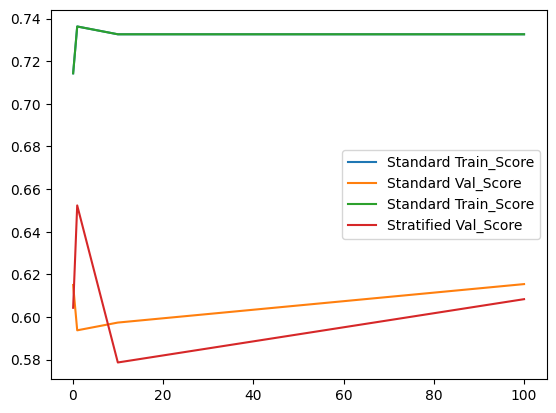

In [42]:
fig,ax = plt.subplots()
ax.plot(k_values,mean_train_errors_std,label="Standard Train_Score")
ax.plot(k_values,mean_val_errors_std,label="Standard Val_Score")
ax.plot(k_values,mean_train_errors_strat,label="Standard Train_Score")
ax.plot(k_values,mean_val_errors_strat,label="Stratified Val_Score")
ax.legend()
plt.show()

In [43]:
print(f"Lowest Standrad Training mean Error is {np.min(mean_train_errors_std)} at  C =  {k_values[np.argmin(mean_train_errors_std)]}")
print(f"Lowest Standrad Val mean Error is {np.min(mean_val_errors_std)}  at  C = {k_values[np.argmin(mean_val_errors_std)]}")
print(f"Lowest Stratified Training mean Error is {np.min(mean_train_errors_strat)} at C = {k_values[np.argmin(mean_train_errors_strat)]}")
print(f"Lowest Stratified Val mean Error is {np.min(mean_val_errors_strat)} at C = {k_values[np.argmin(mean_val_errors_strat)]}")

Lowest Standrad Training mean Error is 0.7142857142857143 at  C =  0.1
Lowest Standrad Val mean Error is 0.5937373737373737  at  C = 1
Lowest Stratified Training mean Error is 0.7142857142857143 at C = 0.1
Lowest Stratified Val mean Error is 0.5786531986531986 at C = 10


As Stratified Val error is lowest at C = 10

In [44]:
svc = LinearSVC(C=10)
svc.fit(scalled_x_train,y_train)

LinearSVC(C=10)

In [45]:
error = svc.score(scalled_x_test,y_test)

In [46]:
error

0.5652173913043478

Test Score = 0.5652173913043478